# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:26<00:00, 2.29KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

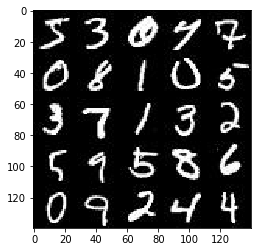

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

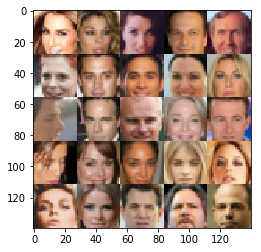

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/Users/dchaplinsky/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return (
        tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels)),
        tf.placeholder(tf.float32, shape=(None, z_dim)),
        tf.placeholder(tf.float32)
    )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [51]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # INPUT 28x28xDEPTH
        x = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding="SAME", activation=None)
        x = tf.maximum(x, x * alpha)
        # INPUT 14x14x64

        x = tf.layers.conv2d(inputs=x, filters=128, kernel_size=5, strides=2, padding="SAME", activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, x * alpha)
        # INPUT 7x7x128

        x = tf.layers.conv2d(inputs=x, filters=256, kernel_size=5, strides=2, padding="SAME", activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, x * alpha)
        # INPUT 4x4x256

        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=x, units=1, activation=None)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [52]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(inputs=z, units=7*7*256, activation=None)
        x = tf.reshape(x, shape=(-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, x * alpha)

        x = tf.layers.conv2d_transpose(inputs=x, filters=128, kernel_size=5, strides=2, padding="SAME", activation=None)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, x * alpha)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(inputs=x, filters=64, kernel_size=5, strides=2, padding="SAME", activation=None)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, x * alpha)
        # 28x28x64

        logits = tf.layers.conv2d_transpose(inputs=x, filters=out_channel_dim, kernel_size=5, strides=1, padding="SAME", activation=None)
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [53]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen = generator(input_z, out_channel_dim, alpha=alpha)
    dis_real_out, dis_real_logits = discriminator(input_real, reuse=False, alpha=alpha)
    dis_fake_out, dis_fake_logits = discriminator(gen, reuse=True, alpha=alpha)

    # TODO: randomize it around 0 and 1?
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=dis_real_logits, labels=tf.ones_like(dis_real_out)))

    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=dis_fake_logits, labels=tf.zeros_like(dis_fake_out)))

    g_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=dis_fake_logits, labels=tf.ones_like(dis_fake_out)))



    return d_real_loss + d_fake_loss, g_fake_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [54]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [60]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = 3 if data_image_mode == "RGB" else 1

    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    

    # TODO: also add samples?
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
            
                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 0.7137... Generator Loss: 25.8188
Epoch 1/3... Discriminator Loss: 0.0002... Generator Loss: 19.5573
Epoch 1/3... Discriminator Loss: 0.0159... Generator Loss: 8.3876
Epoch 1/3... Discriminator Loss: 0.0133... Generator Loss: 6.3544
Epoch 1/3... Discriminator Loss: 0.6795... Generator Loss: 3.7891
Epoch 1/3... Discriminator Loss: 0.9001... Generator Loss: 7.6306
Epoch 1/3... Discriminator Loss: 0.8685... Generator Loss: 1.2661
Epoch 1/3... Discriminator Loss: 0.6084... Generator Loss: 4.0310
Epoch 1/3... Discriminator Loss: 0.4782... Generator Loss: 3.1120
Epoch 1/3... Discriminator Loss: 0.6501... Generator Loss: 2.2177


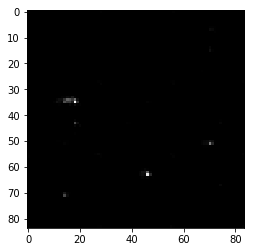

Epoch 1/3... Discriminator Loss: 0.7525... Generator Loss: 1.0531
Epoch 1/3... Discriminator Loss: 0.2787... Generator Loss: 3.2917
Epoch 1/3... Discriminator Loss: 0.0682... Generator Loss: 3.3728
Epoch 1/3... Discriminator Loss: 0.0278... Generator Loss: 4.1654
Epoch 1/3... Discriminator Loss: 0.0690... Generator Loss: 3.2918
Epoch 1/3... Discriminator Loss: 0.0655... Generator Loss: 3.1671
Epoch 1/3... Discriminator Loss: 0.0103... Generator Loss: 5.4406
Epoch 1/3... Discriminator Loss: 5.3762... Generator Loss: 0.0291
Epoch 1/3... Discriminator Loss: 2.9696... Generator Loss: 0.1639
Epoch 1/3... Discriminator Loss: 1.0930... Generator Loss: 1.2123


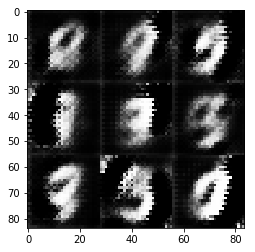

Epoch 1/3... Discriminator Loss: 1.1191... Generator Loss: 0.7816
Epoch 1/3... Discriminator Loss: 1.2646... Generator Loss: 1.1211
Epoch 1/3... Discriminator Loss: 0.6372... Generator Loss: 1.1962
Epoch 1/3... Discriminator Loss: 0.8690... Generator Loss: 1.9364
Epoch 1/3... Discriminator Loss: 0.8407... Generator Loss: 0.7450
Epoch 1/3... Discriminator Loss: 0.8529... Generator Loss: 2.4732
Epoch 1/3... Discriminator Loss: 0.1740... Generator Loss: 2.6010
Epoch 1/3... Discriminator Loss: 0.0726... Generator Loss: 3.3783
Epoch 1/3... Discriminator Loss: 0.0592... Generator Loss: 3.5588
Epoch 1/3... Discriminator Loss: 0.0662... Generator Loss: 3.4910


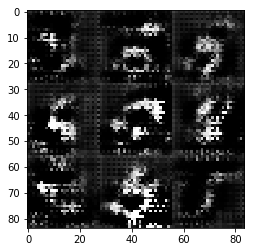

Epoch 1/3... Discriminator Loss: 0.0735... Generator Loss: 5.8966
Epoch 1/3... Discriminator Loss: 1.7330... Generator Loss: 8.4877
Epoch 1/3... Discriminator Loss: 1.0014... Generator Loss: 1.1260
Epoch 1/3... Discriminator Loss: 0.4786... Generator Loss: 1.4465
Epoch 1/3... Discriminator Loss: 0.9888... Generator Loss: 0.5764
Epoch 1/3... Discriminator Loss: 0.0884... Generator Loss: 3.4542
Epoch 1/3... Discriminator Loss: 0.0862... Generator Loss: 3.1523
Epoch 1/3... Discriminator Loss: 0.0805... Generator Loss: 3.7018
Epoch 1/3... Discriminator Loss: 0.0207... Generator Loss: 7.8028
Epoch 1/3... Discriminator Loss: 0.0456... Generator Loss: 7.9133


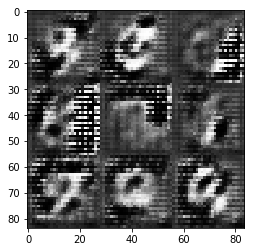

Epoch 1/3... Discriminator Loss: 0.0187... Generator Loss: 7.9214
Epoch 1/3... Discriminator Loss: 0.0276... Generator Loss: 4.8352
Epoch 1/3... Discriminator Loss: 0.3062... Generator Loss: 2.0220
Epoch 1/3... Discriminator Loss: 0.0230... Generator Loss: 10.2094
Epoch 1/3... Discriminator Loss: 0.0390... Generator Loss: 5.3159
Epoch 1/3... Discriminator Loss: 0.0110... Generator Loss: 6.1429
Epoch 2/3... Discriminator Loss: 0.0096... Generator Loss: 7.9562
Epoch 2/3... Discriminator Loss: 0.0412... Generator Loss: 4.2153
Epoch 2/3... Discriminator Loss: 0.0093... Generator Loss: 7.4031
Epoch 2/3... Discriminator Loss: 0.0167... Generator Loss: 5.7604


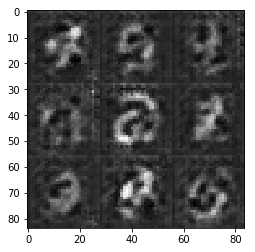

Epoch 2/3... Discriminator Loss: 0.7369... Generator Loss: 0.9701
Epoch 2/3... Discriminator Loss: 0.1389... Generator Loss: 3.7599
Epoch 2/3... Discriminator Loss: 0.6198... Generator Loss: 1.0758
Epoch 2/3... Discriminator Loss: 0.0423... Generator Loss: 5.0358
Epoch 2/3... Discriminator Loss: 0.0530... Generator Loss: 4.5814
Epoch 2/3... Discriminator Loss: 0.0095... Generator Loss: 8.2630
Epoch 2/3... Discriminator Loss: 0.0180... Generator Loss: 6.2607
Epoch 2/3... Discriminator Loss: 0.0446... Generator Loss: 4.5435
Epoch 2/3... Discriminator Loss: 0.0495... Generator Loss: 5.9446
Epoch 2/3... Discriminator Loss: 0.0461... Generator Loss: 10.4551


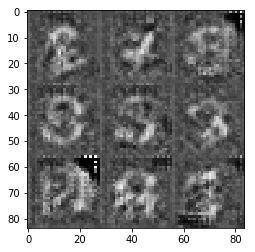

Epoch 2/3... Discriminator Loss: 0.0837... Generator Loss: 3.9085
Epoch 2/3... Discriminator Loss: 0.0645... Generator Loss: 3.6871
Epoch 2/3... Discriminator Loss: 0.0392... Generator Loss: 4.6509
Epoch 2/3... Discriminator Loss: 0.0126... Generator Loss: 5.7671
Epoch 2/3... Discriminator Loss: 0.0211... Generator Loss: 7.9376
Epoch 2/3... Discriminator Loss: 0.0117... Generator Loss: 6.1830
Epoch 2/3... Discriminator Loss: 4.0674... Generator Loss: 0.0442
Epoch 2/3... Discriminator Loss: 0.5039... Generator Loss: 1.5098
Epoch 2/3... Discriminator Loss: 0.1498... Generator Loss: 4.7332
Epoch 2/3... Discriminator Loss: 1.2110... Generator Loss: 2.1687


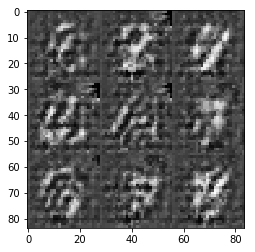

Epoch 2/3... Discriminator Loss: 0.7261... Generator Loss: 2.1516
Epoch 2/3... Discriminator Loss: 0.4009... Generator Loss: 1.8147
Epoch 2/3... Discriminator Loss: 0.1057... Generator Loss: 3.3370
Epoch 2/3... Discriminator Loss: 2.7551... Generator Loss: 4.3733
Epoch 2/3... Discriminator Loss: 0.9958... Generator Loss: 1.4327
Epoch 2/3... Discriminator Loss: 0.7039... Generator Loss: 2.3353
Epoch 2/3... Discriminator Loss: 0.3073... Generator Loss: 5.1202
Epoch 2/3... Discriminator Loss: 1.4417... Generator Loss: 0.4147
Epoch 2/3... Discriminator Loss: 0.3480... Generator Loss: 2.3765
Epoch 2/3... Discriminator Loss: 0.0172... Generator Loss: 6.5470


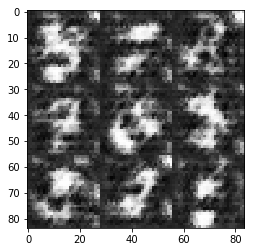

Epoch 2/3... Discriminator Loss: 0.9306... Generator Loss: 2.5034
Epoch 2/3... Discriminator Loss: 0.9424... Generator Loss: 0.8353
Epoch 2/3... Discriminator Loss: 0.5343... Generator Loss: 2.1522
Epoch 2/3... Discriminator Loss: 0.0570... Generator Loss: 3.9432
Epoch 2/3... Discriminator Loss: 0.1927... Generator Loss: 2.3292
Epoch 2/3... Discriminator Loss: 0.0174... Generator Loss: 8.7963
Epoch 2/3... Discriminator Loss: 0.0354... Generator Loss: 6.8338
Epoch 2/3... Discriminator Loss: 0.0511... Generator Loss: 4.3622
Epoch 2/3... Discriminator Loss: 0.0112... Generator Loss: 5.7461
Epoch 2/3... Discriminator Loss: 2.3186... Generator Loss: 0.1858


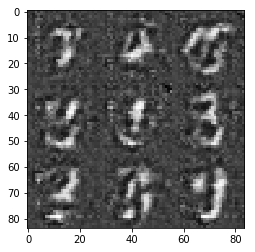

Epoch 2/3... Discriminator Loss: 0.6558... Generator Loss: 1.6666
Epoch 2/3... Discriminator Loss: 0.7288... Generator Loss: 1.1194
Epoch 2/3... Discriminator Loss: 0.9374... Generator Loss: 3.4497
Epoch 3/3... Discriminator Loss: 1.4489... Generator Loss: 4.4048
Epoch 3/3... Discriminator Loss: 0.2699... Generator Loss: 2.5233
Epoch 3/3... Discriminator Loss: 0.7208... Generator Loss: 2.4361
Epoch 3/3... Discriminator Loss: 0.5829... Generator Loss: 2.6905
Epoch 3/3... Discriminator Loss: 0.0459... Generator Loss: 4.7553
Epoch 3/3... Discriminator Loss: 0.2467... Generator Loss: 1.8959
Epoch 3/3... Discriminator Loss: 0.4834... Generator Loss: 1.1510


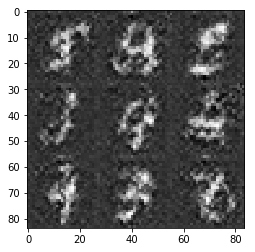

Epoch 3/3... Discriminator Loss: 0.4172... Generator Loss: 2.4848
Epoch 3/3... Discriminator Loss: 0.1835... Generator Loss: 2.2098
Epoch 3/3... Discriminator Loss: 0.0182... Generator Loss: 5.0154
Epoch 3/3... Discriminator Loss: 0.1443... Generator Loss: 2.3270
Epoch 3/3... Discriminator Loss: 0.0666... Generator Loss: 4.7689
Epoch 3/3... Discriminator Loss: 0.1080... Generator Loss: 2.6439
Epoch 3/3... Discriminator Loss: 0.0192... Generator Loss: 5.4472
Epoch 3/3... Discriminator Loss: 0.0180... Generator Loss: 4.9072
Epoch 3/3... Discriminator Loss: 0.0247... Generator Loss: 7.7821
Epoch 3/3... Discriminator Loss: 0.0350... Generator Loss: 3.8441


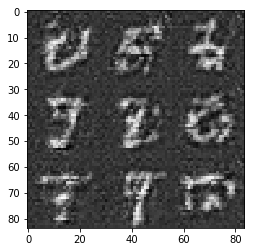

Epoch 3/3... Discriminator Loss: 1.6457... Generator Loss: 0.4431
Epoch 3/3... Discriminator Loss: 1.1440... Generator Loss: 0.5939
Epoch 3/3... Discriminator Loss: 1.0123... Generator Loss: 0.8256
Epoch 3/3... Discriminator Loss: 0.8170... Generator Loss: 1.0703
Epoch 3/3... Discriminator Loss: 0.9932... Generator Loss: 0.7903
Epoch 3/3... Discriminator Loss: 0.9932... Generator Loss: 0.8242
Epoch 3/3... Discriminator Loss: 0.9314... Generator Loss: 0.7567
Epoch 3/3... Discriminator Loss: 0.7155... Generator Loss: 1.4436
Epoch 3/3... Discriminator Loss: 0.9551... Generator Loss: 2.1472
Epoch 3/3... Discriminator Loss: 1.2249... Generator Loss: 0.4956


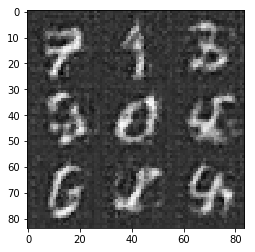

Epoch 3/3... Discriminator Loss: 0.5920... Generator Loss: 1.6550
Epoch 3/3... Discriminator Loss: 1.1442... Generator Loss: 0.5121
Epoch 3/3... Discriminator Loss: 1.2631... Generator Loss: 3.0085
Epoch 3/3... Discriminator Loss: 0.5555... Generator Loss: 1.6488
Epoch 3/3... Discriminator Loss: 0.9103... Generator Loss: 0.6782
Epoch 3/3... Discriminator Loss: 0.5206... Generator Loss: 1.4523
Epoch 3/3... Discriminator Loss: 0.4315... Generator Loss: 1.8923
Epoch 3/3... Discriminator Loss: 0.4486... Generator Loss: 1.5168
Epoch 3/3... Discriminator Loss: 0.3330... Generator Loss: 1.9793
Epoch 3/3... Discriminator Loss: 2.0975... Generator Loss: 0.2121


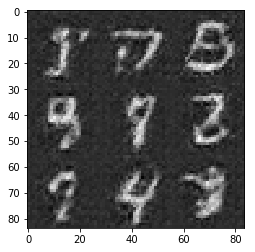

Epoch 3/3... Discriminator Loss: 0.4216... Generator Loss: 1.6237
Epoch 3/3... Discriminator Loss: 0.1308... Generator Loss: 2.9467
Epoch 3/3... Discriminator Loss: 0.0867... Generator Loss: 4.2136
Epoch 3/3... Discriminator Loss: 3.2295... Generator Loss: 0.0872
Epoch 3/3... Discriminator Loss: 0.9151... Generator Loss: 0.8941
Epoch 3/3... Discriminator Loss: 0.3327... Generator Loss: 1.9709
Epoch 3/3... Discriminator Loss: 1.2381... Generator Loss: 0.6426
Epoch 3/3... Discriminator Loss: 0.5945... Generator Loss: 1.4233
Epoch 3/3... Discriminator Loss: 1.1133... Generator Loss: 0.5190
Epoch 3/3... Discriminator Loss: 0.3423... Generator Loss: 1.8412


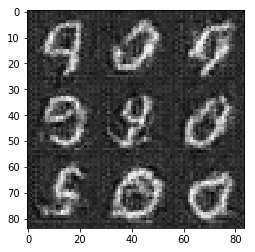

In [63]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 9.9999
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 17.8986
Epoch 1/1... Discriminator Loss: 0.0057... Generator Loss: 15.8693
Epoch 1/1... Discriminator Loss: 0.2583... Generator Loss: 3.9405
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.7486
Epoch 1/1... Discriminator Loss: 0.1677... Generator Loss: 3.4599
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 8.0247
Epoch 1/1... Discriminator Loss: 4.3761... Generator Loss: 12.8245
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 2.6860
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 4.3104


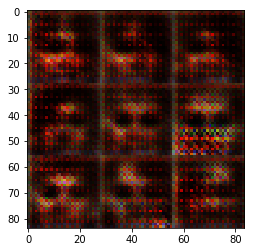

Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 3.2668
Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 5.1947
Epoch 1/1... Discriminator Loss: 0.0265... Generator Loss: 4.5345
Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 13.0361
Epoch 1/1... Discriminator Loss: 4.8617... Generator Loss: 9.7145
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 4.9721
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 2.0617
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.8553
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 5.7109
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 4.6721


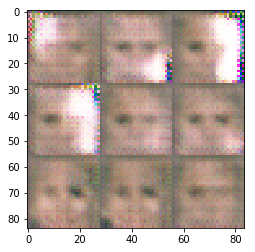

Epoch 1/1... Discriminator Loss: 0.0422... Generator Loss: 3.9572
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.6690
Epoch 1/1... Discriminator Loss: 0.2171... Generator Loss: 2.2708
Epoch 1/1... Discriminator Loss: 0.1542... Generator Loss: 2.2493
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 3.3280
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.3708
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 1.6678
Epoch 1/1... Discriminator Loss: 0.2964... Generator Loss: 4.6822
Epoch 1/1... Discriminator Loss: 0.1217... Generator Loss: 2.5544


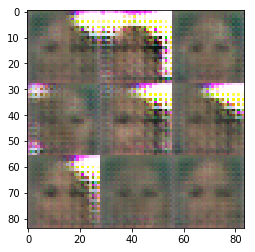

Epoch 1/1... Discriminator Loss: 0.0381... Generator Loss: 4.7039
Epoch 1/1... Discriminator Loss: 0.1732... Generator Loss: 3.5484
Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 4.6409
Epoch 1/1... Discriminator Loss: 1.9642... Generator Loss: 0.3128
Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 2.5047
Epoch 1/1... Discriminator Loss: 0.0862... Generator Loss: 3.1951
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 5.8238
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 4.3579
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.6013
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 1.6290


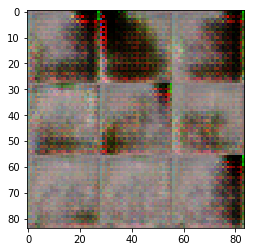

Epoch 1/1... Discriminator Loss: 0.3203... Generator Loss: 3.4263
Epoch 1/1... Discriminator Loss: 0.2585... Generator Loss: 3.1709
Epoch 1/1... Discriminator Loss: 0.1343... Generator Loss: 2.6991
Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 8.8927
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 4.0141
Epoch 1/1... Discriminator Loss: 0.0641... Generator Loss: 4.1828
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 2.4580
Epoch 1/1... Discriminator Loss: 0.2030... Generator Loss: 2.4038
Epoch 1/1... Discriminator Loss: 0.2094... Generator Loss: 6.9877
Epoch 1/1... Discriminator Loss: 0.2925... Generator Loss: 2.3437


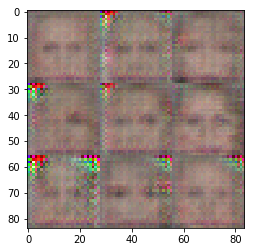

Epoch 1/1... Discriminator Loss: 0.3065... Generator Loss: 3.8729
Epoch 1/1... Discriminator Loss: 2.2488... Generator Loss: 0.1385
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 0.1719... Generator Loss: 2.7425
Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 4.2288
Epoch 1/1... Discriminator Loss: 3.3008... Generator Loss: 4.6982
Epoch 1/1... Discriminator Loss: 0.2718... Generator Loss: 2.4735
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 6.4694
Epoch 1/1... Discriminator Loss: 0.0829... Generator Loss: 4.5968
Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 2.0984


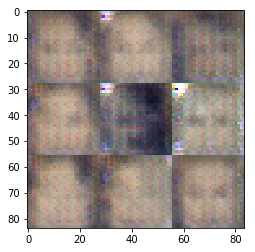

Epoch 1/1... Discriminator Loss: 0.1291... Generator Loss: 4.9658
Epoch 1/1... Discriminator Loss: 0.0873... Generator Loss: 3.6395
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 5.6688
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 8.5911
Epoch 1/1... Discriminator Loss: 0.0306... Generator Loss: 4.6655
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 2.0955
Epoch 1/1... Discriminator Loss: 0.2384... Generator Loss: 7.2718
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 4.2457
Epoch 1/1... Discriminator Loss: 0.2054... Generator Loss: 2.3631
Epoch 1/1... Discriminator Loss: 0.0490... Generator Loss: 3.7323


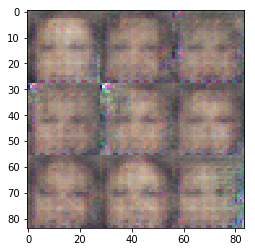

Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 4.2471
Epoch 1/1... Discriminator Loss: 1.8913... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.9781
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 5.2723
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.6944
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.2770
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.0732


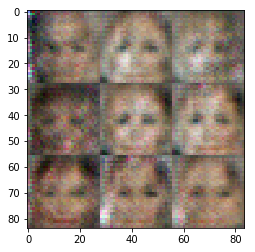

Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 1.4812
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 2.8837
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.4980


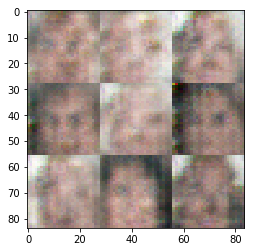

Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 1.7558... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 1.8034... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 0.1643... Generator Loss: 3.9124
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8037


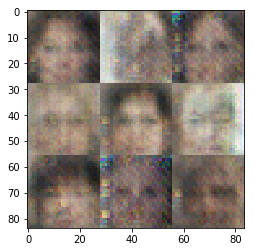

Epoch 1/1... Discriminator Loss: 2.1366... Generator Loss: 1.9868
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 2.5271
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 3.9943
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.3028
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 2.1828
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 4.8806
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 6.8340
Epoch 1/1... Discriminator Loss: 0.2903... Generator Loss: 2.1473


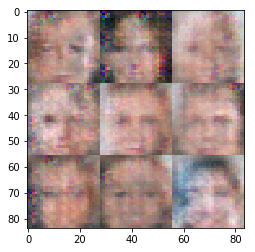

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 0.2810... Generator Loss: 2.1490
Epoch 1/1... Discriminator Loss: 2.5361... Generator Loss: 3.2069
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 3.4567
Epoch 1/1... Discriminator Loss: 4.8732... Generator Loss: 4.7161
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.8466


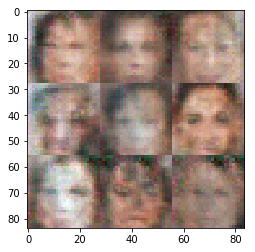

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 1.2334


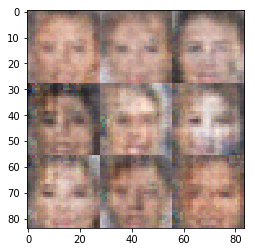

Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.7426
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 2.3432... Generator Loss: 0.1939
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.7690


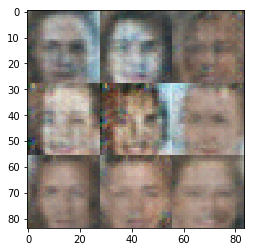

Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.7975
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.2219
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 2.0935


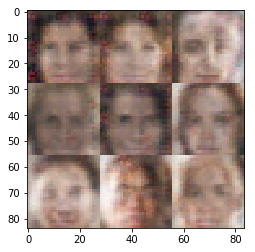

Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.4529
Epoch 1/1... Discriminator Loss: 4.1288... Generator Loss: 5.2408
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.8768
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.5512
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.7586


In [64]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.